<a href="https://colab.research.google.com/github/AV-Gorshkov/Python_netology/blob/main/PY_garch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Домашнее задание**

Выберите ряд из первого задания и постройте его модель GARCH.

In [96]:
!pip install arch

In [97]:
import pandas as pd
import numpy as np

from math import sqrt

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from sklearn.metrics import mean_squared_error

from arch import arch_model

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [104]:
#  загрузка данных
param = r'/content/drive/My Drive/Нетология/ML/Временные_ряды/1_знакомство_с_временными_рядами/Series/'

file = 'international-airline-passengers.csv'

series  = pd.read_csv(f'{param}{file}', sep = ',')

series = series ["Count"]

In [99]:
# функция автокорреляции (сезонность)
def fun_series (y, indx=1):

  total = pd.DataFrame( columns=['Lag','R'])

  for i in range(1, indx + 1):

    ser_a = pd.Series( y[:-i], name='A').reset_index(drop=True)
    ser_b =  pd.Series( y[i:], name='B').reset_index(drop=True)

    df = pd.concat([ser_a, ser_b], axis=1)

    total = pd.concat([total, pd.DataFrame( [ {'Lag': i, 'R': df.corr().at['A','B']} ] ) ])
  return total.sort_values(by='R', ascending=False).reset_index(drop=True)

In [105]:
# Тест Дики-Фуллера

def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [106]:

def tsplot(y, name="originel", lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title(name)

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)

        plt.tight_layout()
    return

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


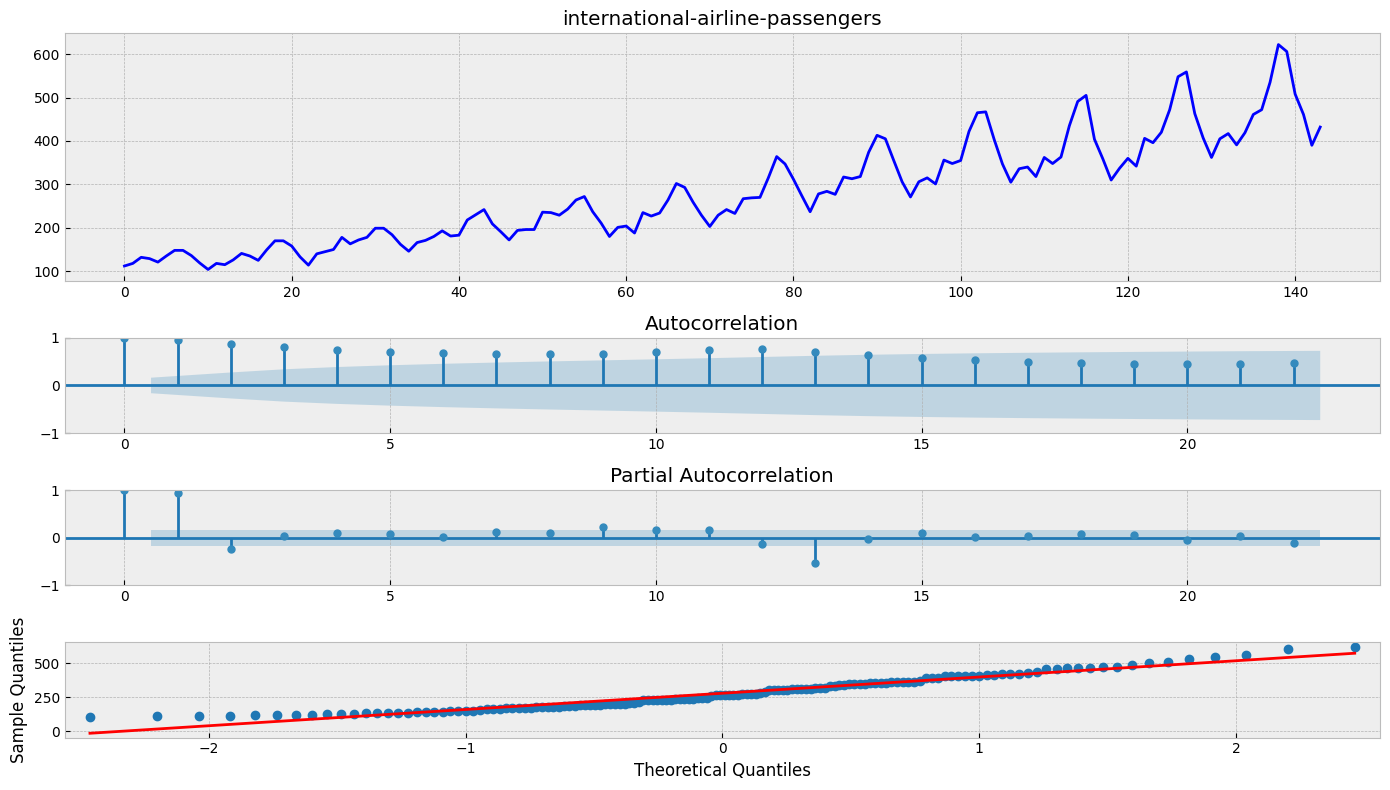

In [107]:
#  Визуализируем, изучим данные

name = 'international-airline-passengers'
tsplot(series , name)

Очевидно, что график нестационарный, имеется и тренд и сезонность. С трендом ARIMA должна справиться.

Методом грубой силы подберем параметры для формулы ARIMA, они нам понадобятся в GARCH:
$$\delta^p y_t = c + \sum_{i=1}^p a_i \delta^d y_{t-i} + \sum_{j=1}^q b_j \epsilon_{t-j} + \epsilon_t$$  
p - порядок авторегрессии тренда;  
d - порядок изменения тренда (степень дифференцирования);  
q - тренд скользящей средней.

In [109]:
# модель ARIMA
# p - порядок авторегрессии тренда;
# d - порядок изменения тренда (степень дифференцирования);
# q - тренд скользящей средней.

# фунцкия ARIMA
def model_arima (series):
  best_aic = np.inf
  best_order = None
  best_mdl = None

  for i in range(5):
      for d in range(5):
          for j in range(5):
              try:
                  tmp_mdl = ARIMA(series, order=(i,d,j), trend='n')
                  tmp_mdl = tmp_mdl.fit()
                  tmp_aic = tmp_mdl.aic
                  if tmp_aic < best_aic:
                      best_aic = tmp_aic
                      best_order = (i, d, j)
                      best_mdl = tmp_mdl
              except: continue
  return best_order, best_mdl

In [110]:
best_order, best_mdl = model_arima(series)

print(f" Параметры модели: p = {best_order[0]}, d = {best_order[1]}, q = {best_order[2]}.")

 Параметры модели: p = 4, d = 1, q = 4.


Модель GARCH описывается формулой (аналог ARMA, только применимо к дисперсии):

$$\sigma_t^2 = V(u_t | u_{t-1}, ..., u_{t-q}) = \alpha_0 + \sum_{i=1}^q \alpha_i u_{t-i}^2 + \sum_{j=1}^p \beta_j \sigma_{t-j}^2$$

In [112]:
# сезонность
slen = fun_series (series, indx=24)['Lag'][0]

print('сезонность: ', slen)

fun_series (series, indx=24).style.background_gradient(cmap='YlOrRd',axis=0)

сезонность:  12


,Lag,R
0,12,0.990527
1,24,0.983254
2,1,0.960195
3,11,0.949702
4,13,0.948107
5,23,0.936717
6,2,0.895675
7,10,0.882713
8,14,0.875448
9,22,0.859013


In [113]:
garch_series = series.to_numpy()

#  уберем наличие тренда (дифференцирование)
garch_series = garch_series[1:] - garch_series[:-1]

# Уберем влияние сезонности
garch_series = garch_series[slen:] -garch_series[:-slen]

# Преобразование серии в числовой формат
garch_series  = garch_series .astype(float)

garch_series

array([  5.,   1.,  -3.,  -2.,  10.,   8.,   0.,   0.,  -8.,  -4.,  12.,
         8.,  -6.,  13.,  -9.,  19., -18.,   0.,   0.,  -3.,   3.,   3.,
        -6.,   0.,   4., -15.,   3.,  -7.,  29.,  -9.,  12., -18.,   4.,
        -3.,   2.,  -3.,  -9.,  27.,  11.,  -8., -21.,   9.,  -4.,  -2.,
        -8., -12.,  -1.,   1., -16.,   7.,  -7.,  13.,  16.,  17., -17.,
         1.,  -4.,   5.,   5.,  10.,   7., -13.,  10.,  -6.,  15.,  11.,
        -8.,  -1.,  -8., -11.,  15.,  -7.,   2.,   6.,  -6.,   4.,  11.,
       -10.,   9., -15., -11.,   2.,  -6.,   3.,  -7.,  15.,  -4.,   2.,
        11.,   4.,  10., -13.,  -8.,  -7.,  -4.,  -5.,  -8., -11.,  -6.,
         8.,   5.,  13.,  12., -38.,  12.,  -7.,  -4.,  19.,   4.,  20.,
         4.,   9., -20.,  20.,  -3.,   5., -11.,   4.,  16., -11.,  -8.,
       -36.,  52., -13.,  11.,  11., -27.,  -2.,   9., -26.,  -1.])

Построим GARCH-модель.

In [114]:
# Построим GARCH-модель.
# Использование распределения Стьюдента для улучшения подгонки

garch_mdl = arch_model(garch_series , p=best_order[0], o=best_order[1], q=best_order[2], dist='StudentsT')
garch_mdl = garch_mdl.fit(update_freq=5, disp='off')
print(garch_mdl.summary() )


                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -505.957
Distribution:      Standardized Student's t   AIC:                           1035.91
Method:                  Maximum Likelihood   BIC:                           1070.42
                                              No. Observations:                  131
Date:                      Mon, Jul 29 2024   Df Residuals:                      130
Time:                              20:48:09   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0

Results of Dickey-Fuller Test:
Test Statistic                -1.559562e+01
p-value                        1.856512e-28
#Lags Used                     0.000000e+00
Number of Observations Used    1.300000e+02
Critical Value (1%)           -3.481682e+00
Critical Value (5%)           -2.884042e+00
Critical Value (10%)          -2.578770e+00
dtype: float64


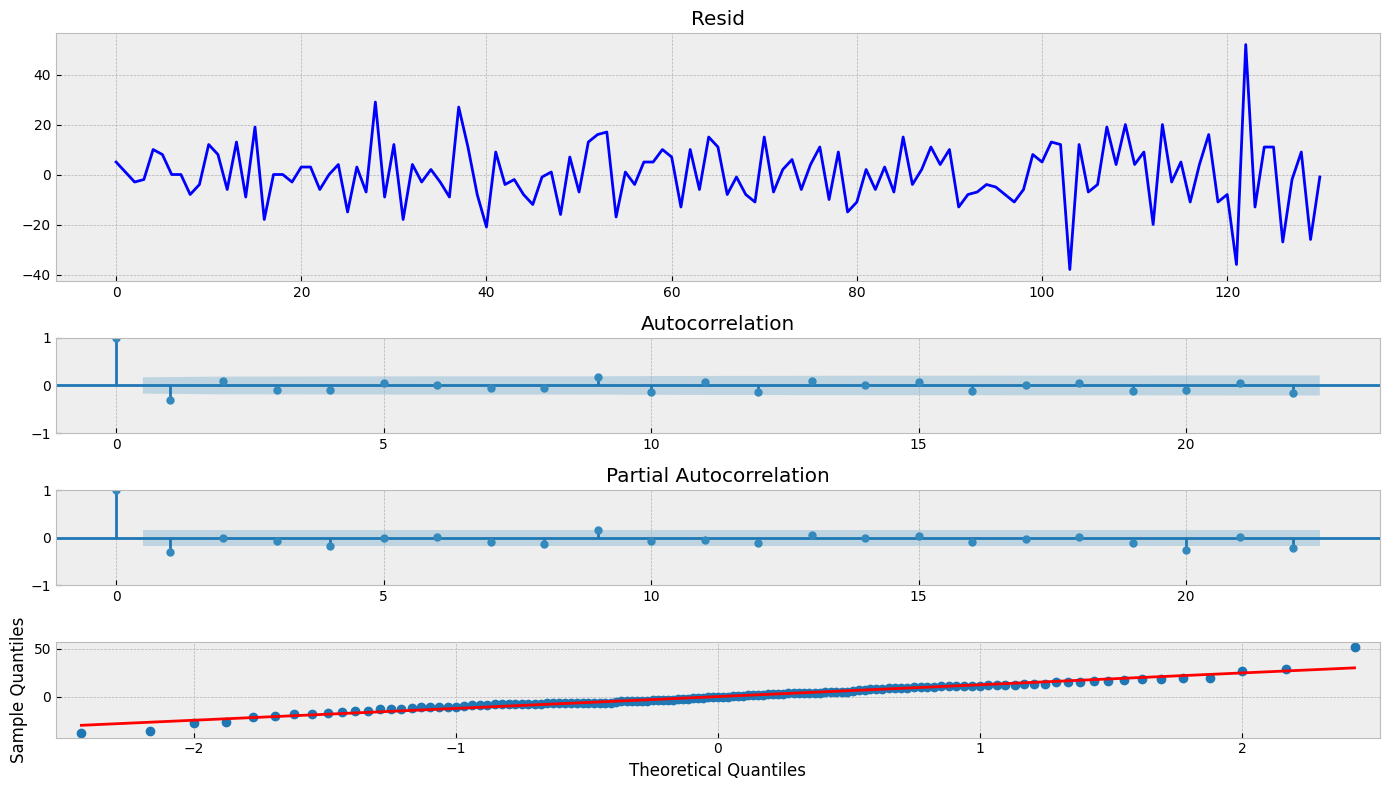

In [115]:
# Построим график остатков дисперсии.

tsplot(garch_mdl.resid , name="Resid") #lags=30)

Модель GARCH хорошо справилась с задачей: p-value меньше 0.05, график остатков похож на "шум", на графике "квантиль-квантиль" точки лежат  (близки) на одной прямой.